### Problem Introduction:
The problem we will tackle is predicting the max temperature for tomorrow in our city using one year of past weather data. I am using Seattle, WA but feel free to find data for your own city using the NOAA Climate Data Online tool. We are going to act as if we don’t have access to any weather forecasts (and besides, it’s more fun to make our own predictions rather than rely on others). What we do have access to is one year of historical max temperatures, the temperatures for the previous two days, and an estimate from a friend who is always claiming to know everything about the weather. This is a supervised, regression machine learning problem. It’s supervised because we have both the features (data for the city) and the targets (temperature) that we want to predict. During training, we give the random forest both the features and targets and it must learn how to map the data to a prediction. Moreover, this is a regression task because the target value is continuous (as opposed to discrete classes in classification).

Data Preparation

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
import pydot

In [30]:
from google.colab import files
uploaded = files.upload()

Saving temps.csv to temps (1).csv


In [31]:
df = pd.read_csv('temps.csv')
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


# Following are the explantion of the features
year : 2016 for all data points

month: number for month of the year

day: number for day of the year

week: day of the week as a character string

temp_2: max temperature 2 days prior

temp_1: max temperature 1 day prior

average: historical average max temperature

actual: max temperature measurement

friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

In [32]:
df.shape

(348, 12)

In [33]:
df.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


One hot encoding (Converting categorical features into numerical features)

In [34]:
#convert categorical variables into dummy/indicator variables
df = pd.get_dummies(df)
df.head()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


In [35]:
print ('Shape of the features after one hot encoding ', df.shape)

Shape of the features after one hot encoding  (348, 18)


Features and Labels

In [36]:
#Features and Labels
labels = np.array(df['actual'])

In [37]:
df = df.drop('actual', axis=1)
features_list = list(df.columns)
final_df = np.array(df)
#final_df


In [38]:
labels

array([45, 44, 41, 40, 44, 51, 45, 48, 50, 52, 45, 49, 55, 49, 48, 54, 50,
       54, 48, 52, 52, 57, 48, 51, 54, 56, 57, 56, 52, 48, 47, 46, 51, 49,
       49, 53, 49, 51, 57, 62, 56, 55, 58, 55, 56, 57, 53, 51, 53, 51, 51,
       60, 59, 61, 60, 57, 53, 58, 55, 59, 57, 64, 60, 53, 54, 55, 56, 55,
       52, 54, 49, 51, 53, 58, 63, 61, 55, 56, 57, 53, 54, 57, 59, 51, 56,
       64, 68, 73, 71, 63, 69, 60, 57, 68, 77, 76, 66, 59, 58, 60, 59, 59,
       60, 68, 77, 89, 81, 81, 73, 64, 65, 55, 59, 60, 61, 64, 61, 68, 77,
       87, 74, 60, 68, 77, 82, 63, 67, 75, 81, 77, 82, 65, 57, 60, 71, 64,
       63, 66, 59, 66, 65, 66, 66, 65, 64, 64, 64, 71, 79, 75, 71, 80, 81,
       92, 86, 85, 67, 65, 67, 65, 70, 66, 60, 67, 71, 67, 65, 70, 76, 73,
       75, 68, 69, 71, 78, 85, 79, 74, 73, 76, 76, 71, 68, 69, 76, 68, 74,
       71, 74, 74, 77, 75, 77, 76, 72, 80, 73, 78, 82, 81, 71, 75, 80, 85,
       79, 83, 85, 88, 76, 73, 77, 73, 75, 80, 79, 72, 72, 73, 72, 76, 80,
       87, 90, 83, 84, 81

In [39]:
final_df

array([[2.016e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.016e+03, 1.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.016e+03, 1.000e+00, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.016e+03, 1.200e+01, 2.900e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.016e+03, 1.200e+01, 3.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.016e+03, 1.200e+01, 3.100e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

Training and Testing sets

In [40]:
#Training and test data sets

print (len(labels))
print (len(final_df))

X_train, X_test, y_train, y_test = train_test_split(final_df, labels, test_size=0.25, random_state=42)

print ('X_train shape = ', X_train.shape)
print ('y_train shape = ', y_train.shape)
print ('X_test shape = ', X_test.shape)
print ('y_test shape = ', y_test.shape)


348
348
X_train shape =  (261, 17)
y_train shape =  (261,)
X_test shape =  (87, 17)
y_test shape =  (87,)


Establish the baseline

In [41]:
#The baseline prediction are the historical avarage temparature
baseline_pred = X_test[:, features_list.index('average')]

#Baseline error, and display average baseline error
baseline_error = abs(baseline_pred - y_test)

#average baseline error
print('Average baseline error: ', round(np.mean(baseline_error), 2), 'degress.')



Average baseline error:  5.06 degress.


Training the Random Forest

In [42]:
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Make prediction on test dataset

In [43]:
#use forest predict method on test data
test_predict = rf.predict(X_test)
#calculate the absolute error
errors = abs(test_predict-y_test)
print ('mean absolute error ', round(np.mean(errors), 2), 'degrees. ')

mean absolute error  3.87 degrees. 


In [44]:
#calculate the mean absolute persentage error
mape = 100*(errors/y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.93 %.


Visualizing single Decision Tree

In [45]:
tree = rf.estimators_[5]

export_graphviz(tree, out_file='tree.dot', feature_names=features_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


smaller tree visualization

In [46]:
rf_small = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
rf_small.fit(X_train, y_train)

tree = rf_small.estimators_[5]
export_graphviz(tree, out_file='small.dot', feature_names=features_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('small.dot')
graph.write_png('small_tree.png')


feature importance

In [47]:
#get numerical feature importance
importances = list(rf.feature_importances_)

#print (importances)
#list of tuples with feature and importance
feature_importance = [(feature, round(importance, 2))for feature, importance in zip(features_list, importances)]

feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse=True)

feature_importance

[('temp_1', 0.66),
 ('average', 0.15),
 ('forecast_noaa', 0.05),
 ('forecast_acc', 0.03),
 ('day', 0.02),
 ('temp_2', 0.02),
 ('forecast_under', 0.02),
 ('friend', 0.02),
 ('month', 0.01),
 ('year', 0.0),
 ('week_Fri', 0.0),
 ('week_Mon', 0.0),
 ('week_Sat', 0.0),
 ('week_Sun', 0.0),
 ('week_Thurs', 0.0),
 ('week_Tues', 0.0),
 ('week_Wed', 0.0)]

Two most important features

In [48]:
#New randomforest with two most important features
rf_most_important = RandomForestRegressor(n_estimators=1000, random_state=42)

#Extract the two most important features
important_indices = [features_list.index('temp_1'), features_list.index('average')]
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]

#Train the randomforest
rf_most_important.fit(train_important, y_train)

#Make prediction and determine the error
test_predict = rf_most_important.predict(test_important)

errors = abs(test_predict - y_test)

#display the performance metrics
print ('mean absolute error: ', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100*(errors/y_test))

accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

mean absolute error:  3.92 degrees.
Accuracy: 93.76 %.


Visualization

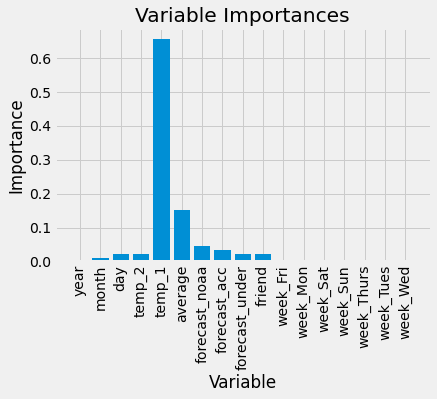

In [49]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 